# Lab: Linear Models and Regularization Methods 


### Step 1: Import Libraries 

In [1]:
# !pip install l0bnb

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, 
                        sklearn_selected,
                        sklearn_selection_path)

from l0bnb import fit_path


### Subset Selection: 
1. Forward Selection 
2. Backward Selection 
3. Best Subset Selection 

# Part I: Forward Selection Type  

In [3]:
Hitters = load_data('Hitters')

In [4]:
Hitters.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N

In [5]:
Hitters.shape

(322, 20)

In [6]:
Hitters.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [7]:
# removes rows with missing values
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [8]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n


In [9]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [10]:
# Set up a scoring function
neg_Cp = partial(nCp, sigma2)

In [11]:
# Explain the function
#   - sigma2: the estimated error variance
#   - estimator: a fitted model
#   - X: the design matrix
#   - Y: the response vector
#   - n: the number of observations 
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [12]:
strategy

Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7a2b7e73c760>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=<function first_peak at 0x7a2b4859bf40>, postprocess=<function _postprocess_best at 0x7a2b485bc1f0>)

In [13]:
Hitters.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   
5    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  
5   336     194      A        W      282      421      25   750.0         A

In [14]:
# 
hitters_MSE = sklearn_selected(OLS,
                               strategy)
# Fit the model
hitters_MSE.fit(Hitters, Y)
# Get the selected variables
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [15]:
# Create a model selector using OLS and the defined stepwise strategy,
# scoring each model using the negative Mallows' Cp statistic
hitters_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)

# Fit the selected model to the Hitters dataset and target variable Y
hitters_Cp.fit(Hitters, Y)

# View which predictors were selected in the final model
hitters_Cp.selected_state_


('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

In [16]:

strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
# Create a model selector using OLS and the defined stepwise strategy,
# scoring each model using the negative Mallows' Cp statistic
full_path = sklearn_selection_path(OLS, strategy)

In [17]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

### Evaluate in-sample MSE

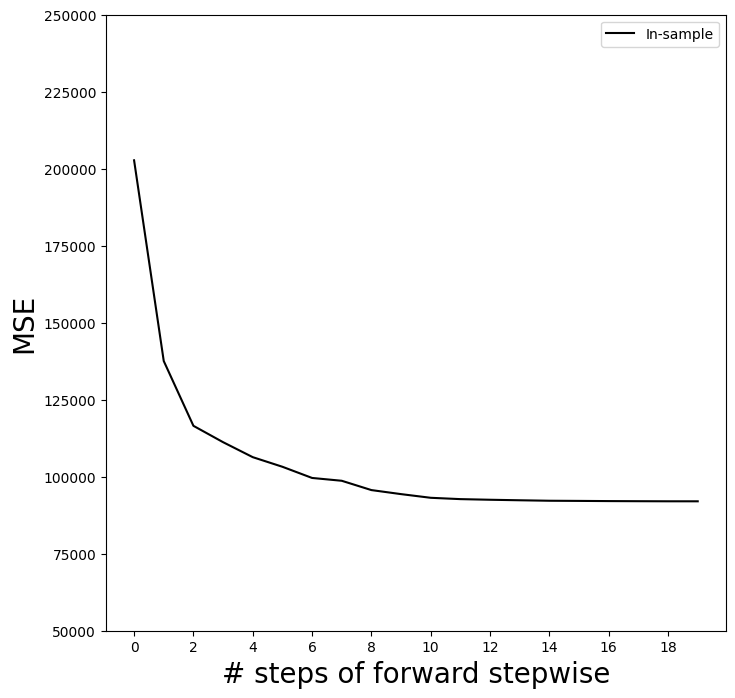

In [18]:
mse_fig, ax = subplots(figsize=(8,8))
# Calculate the mean squared error for each step in the forward stepwise selection
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
# Plot the mean squared error for each step
n_steps = insample_mse.shape[0]
# Plot the mean squared error for each step
ax.plot(np.arange(n_steps),
insample_mse,
'k', # color black
label='In-sample')
ax.set_ylabel('MSE',
fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);

### The cross-validated predicted values using 5-fold crossvalidation.

In [19]:
K=5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
# Create a model selector using OLS and the defined stepwise strategy,
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(263, 20)

In [20]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

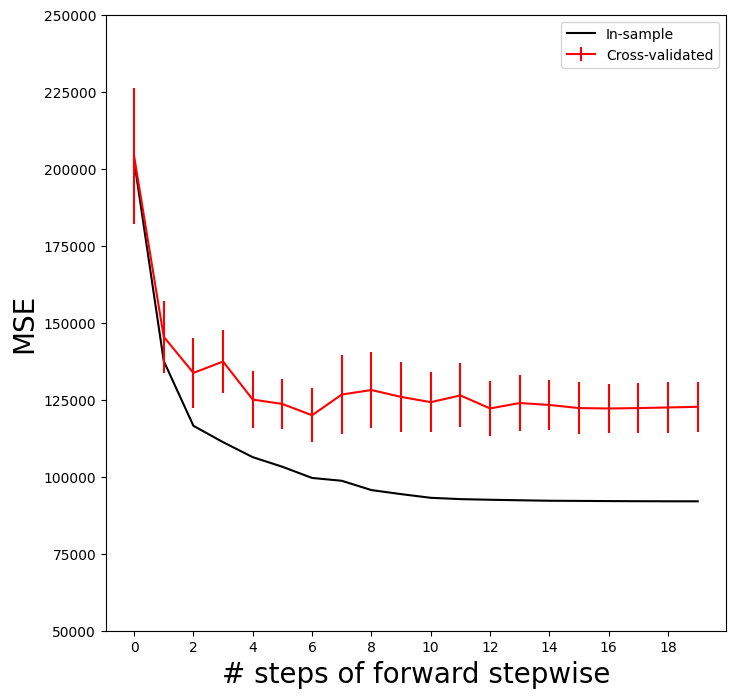

In [21]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
# Plot the mean squared error for each step
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

In [22]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
# Predict the response for the test set
Yhat_val = full_path.predict(Hitters.iloc[test_idx])
errors = (Yhat_val - Y[test_idx,None])**2
validation_mse = errors.mean(0)

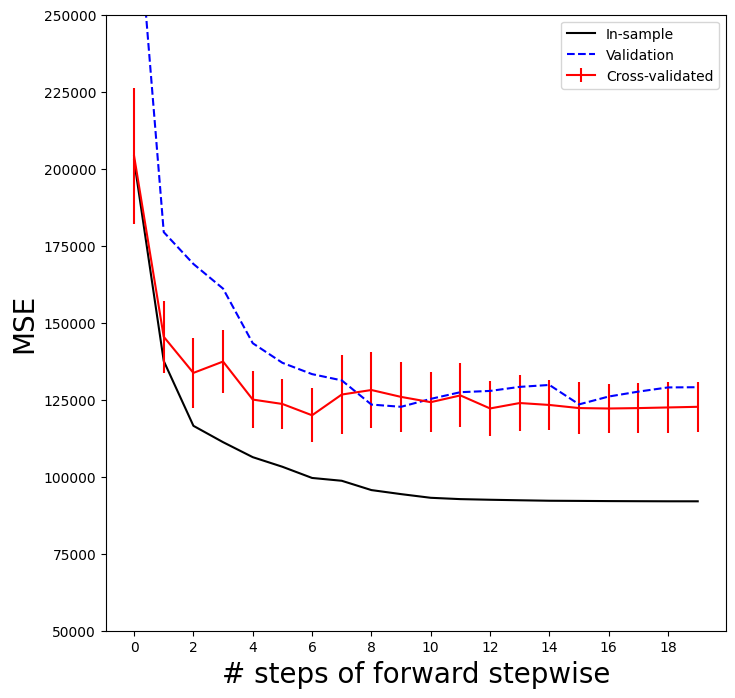

In [23]:
ax.plot(np.arange(n_steps),
validation_mse,
'b--', # color blue, broken line
label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

# Part II: Best Subset Selection 

In [24]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [25]:
D

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
1      315    81      7    24   38     39     14    3449    835      69   
2      479   130     18    66   72     76      3    1624    457      63   
3      496   141     20    65   78     37     11    5628   1575     225   
4      321    87     10    39   42     30      2     396    101      12   
5      594   169      4    74   51     35     11    4408   1133      19   
..     ...   ...    ...   ...  ...    ...    ...     ...    ...     ...   
317    497   127      7    65   48     37      5    2703    806      32   
318    492   136      5    76   50     94     12    5511   1511      39   
319    475   126      3    61   43     52      6    1700    433       7   
320    573   144      9    85   60     78      8    3198    857      97   
321    631   170      9    77   44     31     11    4908   1457      30   

     CRuns  CRBI  CWalks  League[N]  Division[W]  PutOuts  Assists  Errors  \
1      321   414     375        1.0          1.0      632       43      10   
2      224   266     263        0.0          1.0      880       82      14   
3      828   838     354        1.0          0.0      200       11       3   
4       48    46      33        1.0          0.0      805       40       4   
5      501   336     194        0.0          1.0      282      421      25   
..     ...   ...     ...        ...          ...      ...      ...     ...   
317    379   311     138        1.0          0.0      325        9       3   
318    897   451     875        0.0          0.0      313      381      20   
319    217    93     146        0.0          1.0       37      113       7   
320    470   420     332        0.0          0.0     1314      131      12   
321    775   357     249        0.0          1.0      408        4       3   

     NewLeague[N]  
1             1.0  
2             0.0  
3             1.0  
4             1.0  
5             0.0  
..            ...  
317           1.0  
318           0.0  
319           0.0  
320           0.0  
321           0.0  

[263 rows x 19 columns]

In [ ]:

path = fit_path(X,
                Y,
                max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


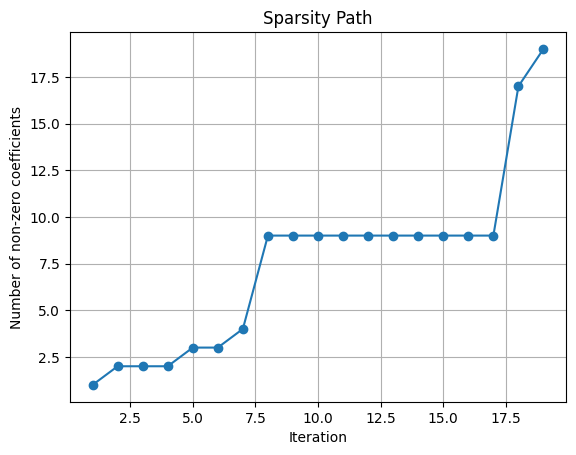

In [27]:
import numpy as np

nonzero_counts = [np.sum(result['B'] != 0) for result in path]

import matplotlib.pyplot as plt

plt.plot(range(1, len(nonzero_counts)+1), nonzero_counts, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Number of non-zero coefficients")
plt.title("Sparsity Path")
plt.grid(True)
plt.show()


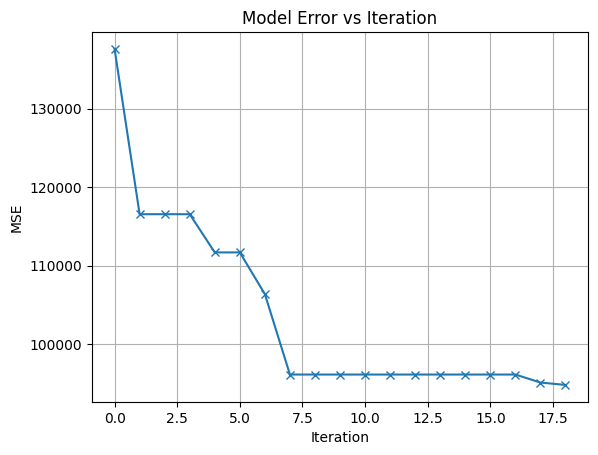

In [28]:
from sklearn.metrics import mean_squared_error

errors = []
for result in path:
    y_pred = X @ result['B'] + result['B0']
    mse = mean_squared_error(Y, y_pred)
    errors.append(mse)

plt.plot(range(len(errors)), errors, marker='x')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Model Error vs Iteration")
plt.grid(True)
plt.show()


In [34]:
path[18]

{'B': array([-1.26502911e+00,  4.46363942e+00, -4.05516420e-01,  3.68642135e-01,
         3.70769174e-01,  4.52419026e+00, -1.09492951e+01, -2.62273508e-02,
         1.75010089e-01,  7.24620342e-01,  4.97558641e-01,  3.27023455e-01,
        -4.83177545e-01,  5.94754193e+01, -1.24109864e+02,  2.75173624e-01,
         2.44689154e-01, -3.85103383e+00, -2.60155377e+01]),
 'B0': 127.13628221208302,
 'lambda_0': 9.180211178141872e-06,
 'M': 0.5447345814105986,
 'Time_exceeded': False}